### Generalized linear model: Bioassay + grid sampling (6 points)
In the bioassay example (Chapter 3 in the book), replace the uniform prior density by a joint normal prior distribution on $(\alpha,\beta)$, with $\alpha ∼ N(0,22)$, $\beta ∼ N(10,102)$, and $corr(\alpha,\beta) = 0.5$.

Hints
 * See demo3_6.m or demo3_6.py
 * Check that the range and spacing of grid for $\alpha$ and $\beta$ are sensible for the alternative prior
 * Compute the log-posterior in a grid
 * Scale the log-posterior by subtracting its maximum value before exponentiating
 * Exponentiate
 * Normalize the posterior
 * Use 2D grid sampling to sample from the posterior
 * In addition to the plots, report $p(\beta > 0|x, y)$
 * Useful Matlab functions: mnorm_lpdf.m, catrand.m, binsgeq.m

** a) Repeat all the computations and plots of Section 3.7 with this new prior distribution.**

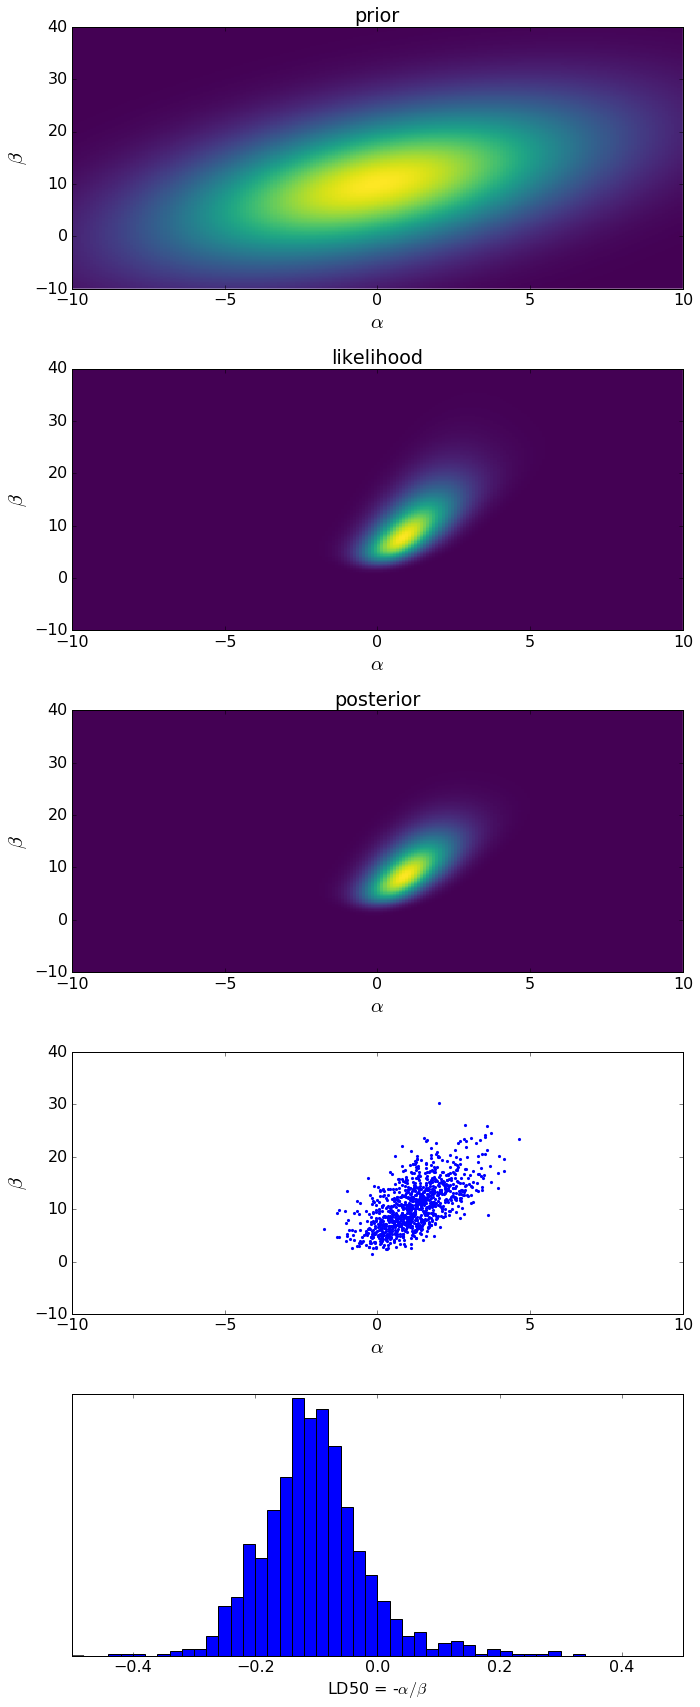

p(beta>0|x,y) > 999/1000


In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
import numpy as np

# Edit default plot settings (colours from colorbrewer2.org)
plt.rc('figure', figsize=(8, 6))
plt.rc('font', size=16)
plt.rc('lines', color='#377eb8', linewidth=2)
plt.set_cmap(plt.get_cmap('viridis'))

# data
x = np.array([-0.86, -0.30, -0.05, 0.73])
n = np.array([5, 5, 5, 5])
y = np.array([0, 1, 3, 5])

alpha_mean = 0
alpha_var = 22
beta_mean = 10
beta_var = 102
corr = 0.5
cov = np.sqrt(alpha_var) * np.sqrt(beta_var) * corr

N = 200
A = np.linspace(-10, 10, N)
B = np.linspace(-10, 40, N)
AB = np.dstack(np.meshgrid(A, B))
prior = stats.multivariate_normal.pdf(AB, [alpha_mean, beta_mean], [[alpha_var, cov], [cov, beta_var]])

theta = 1 / (np.exp(-(A[:, None] + B[:, None, None] * x)) + 1)
loglike = np.sum(np.log(theta ** y * (1 - theta) ** (n - y)), axis=2)
logp = loglike + np.log(prior)
logp -= logp.max()
p = np.exp(logp)
p = p/np.sum(p)

# sample from the grid
nsamp = 1000
samp_indices = np.unravel_index(
    np.random.choice(p.size, size=nsamp, p=p.ravel()),
    p.shape
)
samp_A = A[samp_indices[1]]
samp_B = B[samp_indices[0]]
# add random jitter, see BDA3 p. 76
samp_A += (np.random.rand(nsamp) - 0.5) * (A[1] - A[0])
samp_B += (np.random.rand(nsamp) - 0.5) * (B[1] - B[0])

# samples of LD50 conditional beta > 0
bpi = samp_B > 0
samp_ld50 = -samp_A[bpi] / samp_B[bpi]

# ====== Plotting
plt.figure(figsize=(10, 24))

plt.subplot(5, 1, 1)
plt.imshow(prior, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]), interpolation='none')
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('prior')

plt.subplot(5, 1, 2)
plt.imshow(np.exp(loglike), origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]), interpolation='none')
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('likelihood')

plt.subplot(5, 1, 3)
plt.imshow(p, origin='lower', aspect='auto', extent=(A[0], A[-1], B[0], B[-1]), interpolation='none')
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)
plt.title('posterior')
    
# plot the samples
plt.subplot(5, 1, 4)
plt.scatter(samp_A, samp_B, 10, linewidth=0)
plt.xlim([A[0], A[-1]])
plt.ylim([B[0], B[-1]])
plt.xlabel(r'$\alpha$', fontsize=20)
plt.ylabel(r'$\beta$', fontsize=20)

# plot the histogram of LD50
plt.subplot(5, 1, 5)
plt.hist(samp_ld50, np.arange(-0.5, 0.51, 0.02))
plt.xlim([-0.5, 0.5])
plt.xlabel(r'LD50 = -$\alpha/\beta$', fontsize=16)
plt.yticks(())
plt.tight_layout()
plt.show()

print "p(beta>0|x,y) > %d/%d" % ((np.sum(samp_B>0)-1), samp_B.size)

**b) Check that your contour plot and scatterplot look like a compromise between the prior distribution and the likelihood (as displayed in Figure 3.3).**

Looking closely you can see that the posterior is somewhat more rounded than the likelihood, reflecting the influence of the prior. Since the prior is roughly centered on the likelihood and has a much higher variance than the likelihood the likelihood dominates the posterior.

**c) Discuss the effect of this hypothetical prior information on the conclusions in the applied context.**

$\alpha$ represents the base mortality and $\beta$ the drug dependent mortality.

We're soft constraining $\alpha$ to be approximately between $-10$ and $10$. This corresponds to a range of base mortality (x=0) rates of $logit^{-1}(-10) = 0.0000454$ to $logit^{-1}(10) = 0.9999546$, which is a nice broad range.

We're soft constraining $\beta$ between $-10$ and $30$. Negative $\beta$ means the drug is not harmful but actually decreases mortality. It seems fair to include this posibility. A maximum $\beta$ of 30 might be too small for very hazardous substances (plutonium, cyanide), but it's impossible to say without knowing the scale of $x$.

Given the data, the prior does not influence the results much. The results are nearly identical to the results with a uniform prior in the book.